## A Rough Skeleton of Working Draft
---------------------------------------------------------------------------------------------------------


### Table of Contents:
1. Sypnosis
    - Research Question
    - Summary
<p></p>
2. Our Data Set 
    - Packages Used
    - Loading and Cleansing
    
---------------------------------------------------------------------------------------------------------

### 1.) Sypnosis: 

##### Research Question:
How can an author increase engagement from users on Facebook and can we predict the success of a post using insights from an author's page?


##### Overview:
(description)

---------------------------------------------------------------------------------------------------------

In [36]:
?sample.split()

ERROR: Error in .helpForCall(topicExpr, parent.frame()): no methods for ‘sample.split’ and no documentation for it as a function


### 2.) Dataset

##### Packages Used:

In [45]:
install.packages("caTools")
library(caTools)

library(tidyverse)
library(repr)
library(tidymodels)
library(MASS)
options(repr.matrix.max.rows = 8)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



##### Facebook Data set:
(description)

In [17]:
facebook <- read_csv2("data/dataset_Facebook.csv")

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  `Page total likes` = col_double(),
  Type = col_character(),
  Category = col_double(),
  `Post Month` = col_double(),
  `Post Weekday` = col_double(),
  `Post Hour` = col_double(),
  Paid = col_double(),
  `Lifetime Post Total Reach` = col_double(),
  `Lifetime Post Total Impressions` = col_double(),
  `Lifetime Engaged Users` = col_double(),
  `Lifetime Post Consumers` = col_double(),
  `Lifetime Post Consumptions` = col_double(),
  `Lifetime Post Impressions by people who have liked your Page` = col_double(),
  `Lifetime Post reach by people who like your Page` = col_double(),
  `Lifetime People who have liked your Page and engaged with your post` = col_double(),
  comment = col_double(),
  like = col_double(),
  share = col_double(),
  `Total Interactions` = col_double()
)



In [20]:
# Replacing specified columns to categorical factors
cols <- c("Type", "Category", "Post Month", "Post Weekday", "Post Hour")
facebook[cols] <- lapply(facebook[cols], as.factor)

# Renaming column headers without spaces
facebook_colname_fix <- facebook

facebook_col_name_vec <- gsub(" ", "_", colnames(facebook))
colnames(facebook) <- facebook_col_name_vec

glimpse(facebook)


Rows: 500
Columns: 19
$ Page_total_likes                                                    <dbl> 1…
$ Type                                                                <fct> P…
$ Category                                                            <fct> 2…
$ Post_Month                                                          <fct> 1…
$ Post_Weekday                                                        <fct> 4…
$ Post_Hour                                                           <fct> 3…
$ Paid                                                                <dbl> 0…
$ Lifetime_Post_Total_Reach                                           <dbl> 2…
$ Lifetime_Post_Total_Impressions                                     <dbl> 5…
$ Lifetime_Engaged_Users                                              <dbl> 1…
$ Lifetime_Post_Consumers                                             <dbl> 1…
$ Lifetime_Post_Consumptions                                          <dbl> 1…
$ Lifetime_Post_Impressions_by

### Let us select only the data values relevant to our case scenario

We want to explain the best type of post possible and thus we should first explore the relationship between the metrics produced by a post and the individual post type. The following key performance indicators describe a post's success:
- comments
- likes
- shares
- total interactions (summation of the 3 observations above)

In [96]:
facebook_clean <- dplyr::select(facebook, Type, comment, like, share, Total_Interactions)
facebook_clean

Type,comment,like,share,Total_Interactions
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Photo,4,79,17,100
Status,5,130,29,164
Photo,0,66,14,80
Photo,58,1572,147,1777
⋮,⋮,⋮,⋮,⋮
Photo,0,53,22,75
Photo,4,93,18,115
Photo,7,91,38,136
Photo,0,91,28,119


### Compartmentalization of our data into Training, Validation, and Testing Sets

In [116]:
# We have 500 data points collected
# assume we want at least 100 testable data points

# -----
# METHOD 1: singular training and testing set
# Testing set will be 10% of data collected
# Validation set will be 10% of data collected
# Training data set be 80% of data collected

# -----
# METHOD 2: cross-validation technique
# let us split our data into 4 total groups with a 1:5 ratio of testing and training data. 
# (25 points tested, 100 points for training)


set.seed(99)

# Method 1:
partitionTrain = 0.8
ratioTrainValidation = 7/8

# 80/20 ratio TrainingSet:TestingSet
split <- sample.split(facebook_clean$like, SplitRatio = partitionTrain)
training_validation_data = subset(facebook_clean, split == TRUE)
test_set = subset(facebook_clean, split == FALSE)

split <- sample.split(training_validation_data$like, SplitRatio = ratioTrainValidation)
training_set = subset(training_validation_data, split == TRUE)
validation_set = subset(training_validation_data, split == FALSE)

# ?subset
print("Training Set:")
training_set
print("Validation Set:")
validation_set
print("Testing Set:")
test_set

[1] "Training Set:"


Type,comment,like,share,Total_Interactions
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Photo,4,79,17,100
Status,5,130,29,164
Photo,0,66,14,80
Photo,19,325,49,393
⋮,⋮,⋮,⋮,⋮
Photo,17,185,55,257
Photo,5,53,26,84
Photo,7,91,38,136
Photo,0,91,28,119


[1] "Validation Set:"


Type,comment,like,share,Total_Interactions
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Photo,0,77,15,92
Photo,1,48,9,58
Photo,0,40,13,53
Photo,2,60,7,69
⋮,⋮,⋮,⋮,⋮
Photo,1,28,7,36
Photo,3,148,21,172
Photo,2,69,26,97
Photo,1,79,30,110


[1] "Testing Set:"


Type,comment,like,share,Total_Interactions
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Photo,58,1572,147,1777
Status,1,152,33,186
Link,0,16,2,18
Photo,0,100,17,117
⋮,⋮,⋮,⋮,⋮
Photo,56,360,99,515
Photo,10,125,41,176
Photo,0,53,22,75
Photo,4,93,18,115


Now that we have separated our data into specified sets, we will next explore our training data.

---------------------------------------------------------------------------------------------------------

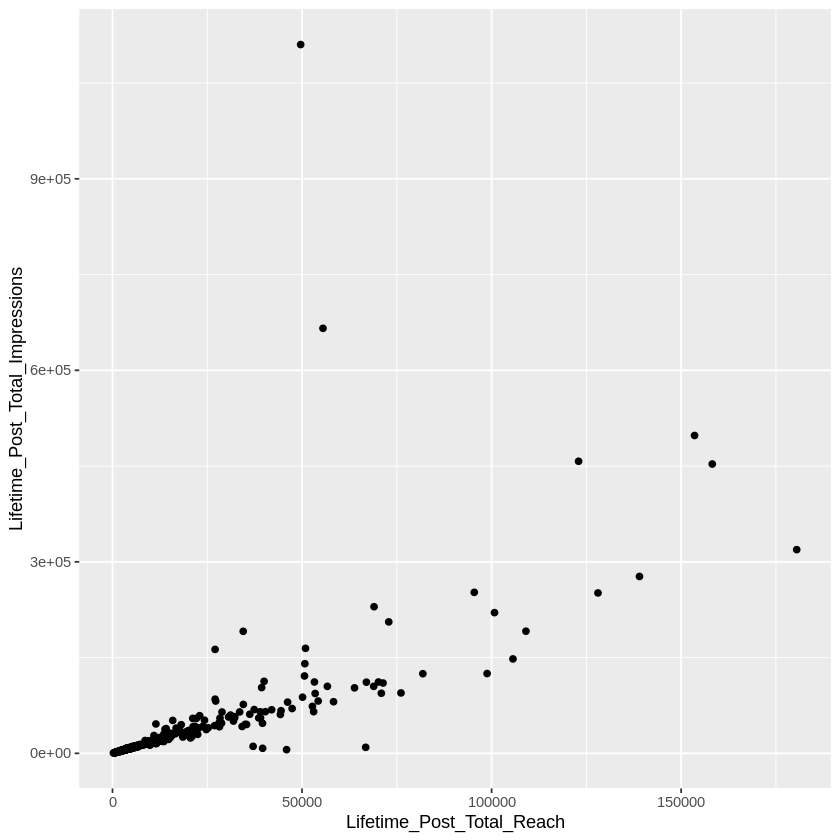

In [23]:
test_plot <- facebook %>% ggplot(aes(x = Lifetime_Post_Total_Reach, y = Lifetime_Post_Total_Impressions)) + geom_point()
test_plot

In [24]:
likes_by_type <- facebook %>%
group_by(Type) %>%
summarise(total_likes = sum(like, na.rm = TRUE))

likes_by_type

`summarise()` ungrouping output (override with `.groups` argument)



Type,total_likes
<fct>,<dbl>
Link,1613
Photo,77610
Status,7952
Video,1620


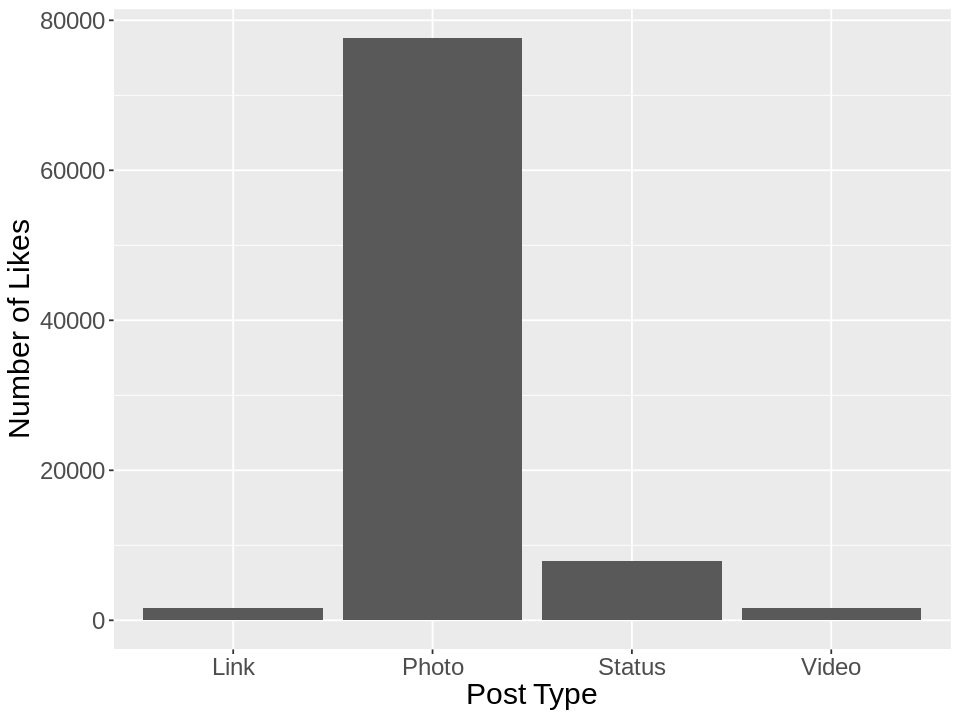

In [25]:
options(repr.plot.width = 8, repr.plot.height = 6) 

likes_bar <- ggplot(likes_by_type, aes(x = Type, y = total_likes)) +
geom_bar(stat = "identity") +
labs(x = "Post Type", y = "Number of Likes") +
theme(text = element_text(size = 18)) 

likes_bar